In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
df=pd.read_csv('/content/sample_data/monthly_milk_production.csv')

In [67]:
df.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [68]:
df.shape

(168, 2)

In [69]:

print(df.columns)

Index(['Date', 'Production'], dtype='object')


Text(0, 0.5, 'Milk Production')

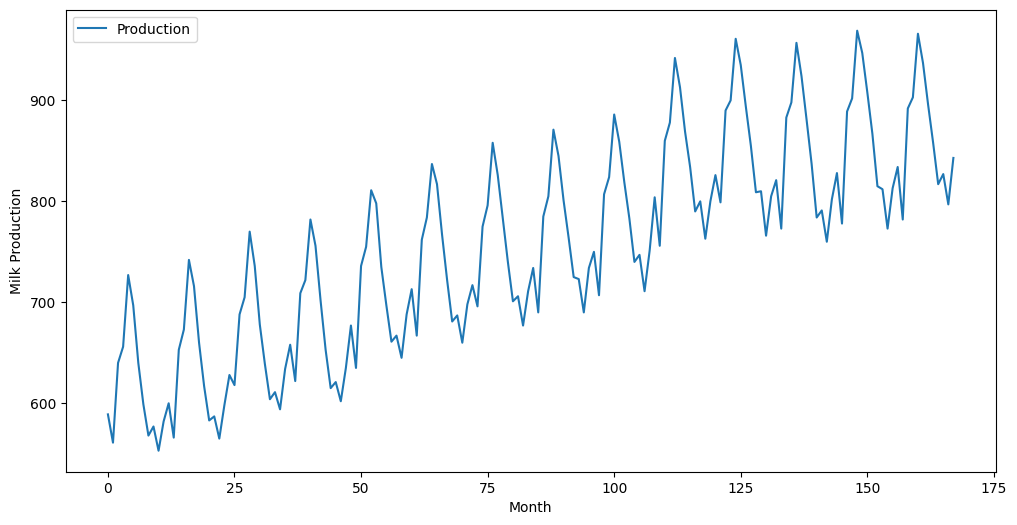

In [70]:
#creating a graph
df.plot(figsize=(12,6))
plt.xlabel("Month")
plt.ylabel("Milk Production")

In [71]:
df.isnull().sum()

,0
Date,0
Production,0


In [72]:
print(df.columns)


Index(['Date', 'Production'], dtype='object')


In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose

it give error so need to change date into datetimeindex.

then set date as index


In [74]:
# Convert the 'Date' column to DateTimeIndex if it's not already
df['Date'] = pd.to_datetime(df['Date'])

In [75]:
# Set 'Date' column as index
df = df.set_index('Date')


**Trend:** The long-term upward or downward movement in the data.

**Seasonality:** The repeating short-term cycles or patterns in the data (e.g., monthly, quarterly, yearly).

**Residual:** The random noise or error component that is left after removing the trend and seasonality.

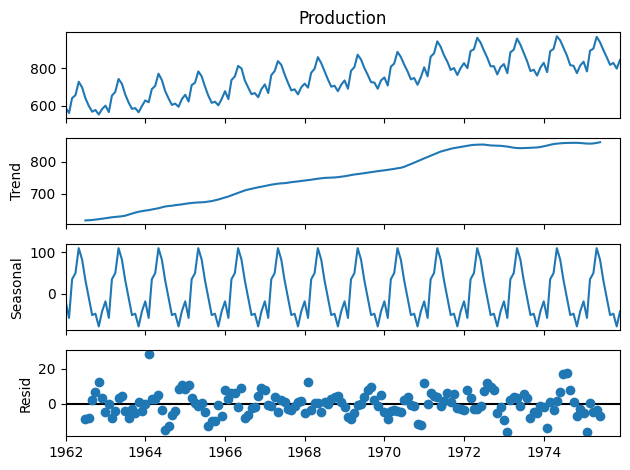

In [76]:
results = seasonal_decompose(df['Production'])
results.plot();

In [77]:

len(df)

168

In [78]:
train = df.iloc[:156]
test = df.iloc[156:]


In [79]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


**minmaxscaler** used because need to convert dataset scale of 0 to 1.


In [80]:

df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [81]:
#find mena,median,deviation
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [82]:
#All values are come in 0 to 1
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [83]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


**Work of timeseriesGenerator :** i/p [1,2,3] -> o/p [4]
                                     
                                  i/p [1,2,3] -> [4] -> [2,3,4] ->[5]
                                  it automatic predict the next value besed on input.

#Example

In [84]:

# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [85]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


**The X.flatten() :** flattens the multi-dimensional array X (likely representing the input sequence) into a 1D array for easier visualization.

In [86]:
X,y = generator[1]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.01923077 0.20913462 0.24759615]
Predict this y: 
 [[0.41826923]]


In [87]:

X.shape

(1, 3, 1)

#actual

In [88]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [89]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [90]:

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [91]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

In [92]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
 20/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2407

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0888
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0226
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0183
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0096
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0167
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0086
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0078
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0069
Epoch 9/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0056
Epoch 10/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045
Epoch 11/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0049
Epoch 12/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0051
Epoch 13/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0037
Epoch 14/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0034
Epoch 15/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.00

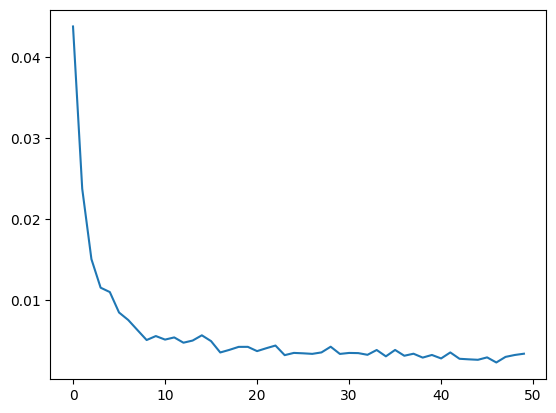

In [93]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)


In [106]:
last_train_batch = scaled_train[-12:]
last_train_batch

array([[0.66105769],
       [0.54086538],
       [0.80769231],
       [0.83894231],
       [1.        ],
       [0.94711538],
       [0.85336538],
       [0.75480769],
       [0.62980769],
       [0.62259615],
       [0.52884615],
       [0.625     ]])

In [107]:

last_train_batch = last_train_batch.reshape((1, n_input, n_features))
last_train_batch

array([[[0.66105769],
        [0.54086538],
        [0.80769231],
        [0.83894231],
        [1.        ],
        [0.94711538],
        [0.85336538],
        [0.75480769],
        [0.62980769],
        [0.62259615],
        [0.52884615],
        [0.625     ]]])

**LSTM expects a 3D input:** (batch_size, time_steps, features).
Here, you're reshaping the last_train_batch to fit this expected format for LSTM input.

**The batch size** is 1 (you're providing one batch).

**n_input** represents the sequence length (e.g., 10 days of data).

**n_features** is the number of features (e.g., temperature, pressure, humidity).

In [108]:
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


array([[0.563212]], dtype=float32)

In [113]:

scaled_test[0]

array([0.67548077])

In [114]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


The current batch is updated by removing the first time step **(current_batch[:, 1:, :])**, and then appending the new predicted value current_pred to the end of the batch.

In [115]:

test_predictions


[array([0.563212], dtype=float32),
 array([0.56243074], dtype=float32),
 array([0.71755624], dtype=float32),
 array([0.80807567], dtype=float32),
 array([0.91554], dtype=float32),
 array([0.90642226], dtype=float32),
 array([0.83835536], dtype=float32),
 array([0.7284503], dtype=float32),
 array([0.6119329], dtype=float32),
 array([0.54964095], dtype=float32),
 array([0.49665594], dtype=float32),
 array([0.5159721], dtype=float32)]

In [116]:
test.head()

,Production,Predictions
Date,,
1975-01-01,834,787.296183
1975-02-01,782,786.971188
1975-03-01,892,851.503395
1975-04-01,903,889.159477
1975-05-01,966,933.864632


In [117]:

true_predictions = scaler.inverse_transform(test_predictions)

In [118]:
test['Predictions'] = true_predictions

<ipython-input-118-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='Date'>

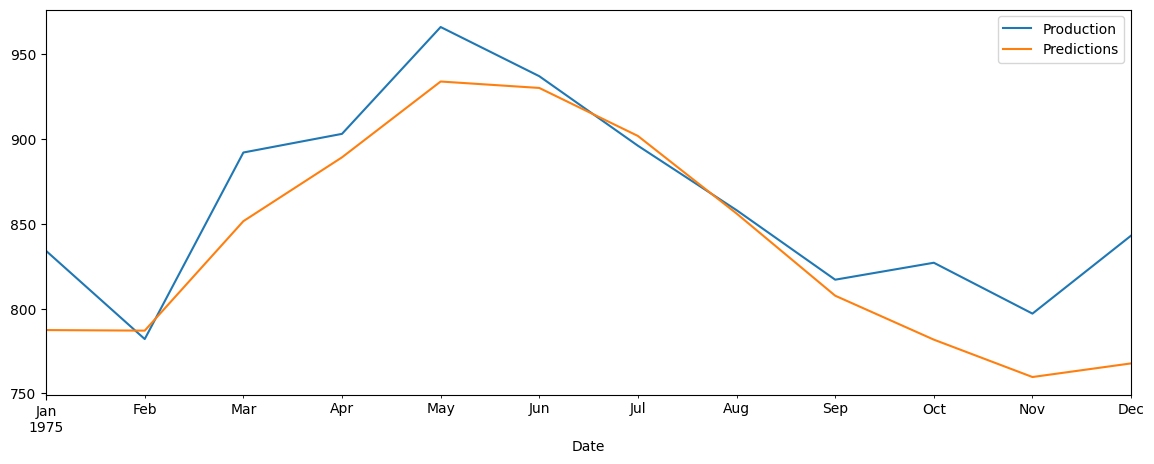

In [119]:
test.plot(figsize=(14,5))

In [120]:

from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

34.61374295138285
